## 1. Introduction
<p><img src="https://assets.datacamp.com/production/project_1230/img/nyc.jpg" alt="New York City skyline" width="600px">
<br>
Welcome to New York City (NYC), one of the most-visited cities in the world. 
As a result, there are many <a href="https://www.airbnb.com/"><em>Airbnb</em></a> listings to meet the high demand for temporary lodging for anywhere between a few nights to many months. 
In this notebook, we will take a look at the NYC Airbnb market by combining data from multiple file types like <code>.csv</code>, and <code>.xlsx</code>.</p>
<p><br><br>
We will be working with three datasets:</p>
<ol>
<li><p><code>"datasets/airbnb_price.csv"</code></p></li>
<li><p><code>"datasets/airbnb_room_type.xlsx"</code></p></li>
<li><p><code>"datasets/airbnb_last_review.csv"</code></p></li>
</ol>
<p><br><br>
Our goals are to convert untidy data into appropriate formats to analyze, and answer key questions including:</p>
<ul>
<li>What is the average price, per night, of an Airbnb listing in NYC? </li>
<li>How does the average price of an Airbnb listing, per month, compare to the private rental market? </li>
<li>How many adverts are for private rooms? </li>
<li>How do Airbnb listing prices compare across the five NYC boroughs?</li>
</ul>

## 2.Data Loading

In [1]:
# Step 1: Importing Libraries and Loading Data
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML 

# Load datasets
review_address = "/kaggle/input/new-york-city-airbnb-market/airbnb_last_review.csv"
price_address = "/kaggle/input/new-york-city-airbnb-market/airbnb_price.csv"
room_address = "/kaggle/input/new-york-city-airbnb-market/airbnb_room_type.xlsx"

reviews = pd.read_csv(review_address)
prices = pd.read_csv(price_address)
rooms = pd.read_excel(room_address)

# Display dataframes side by side for initial inspection
def side_by_side(*objs):
    return HTML(pd.concat(objs, axis=1).to_html())

side_by_side(prices.head(), rooms.head(), reviews.head())

,listing_id,price,nbhood_full,listing_id,description,room_type,listing_id,host_name,last_review
0,2595,225 dollars,"Manhattan, Midtown",2595,Skylit Midtown Castle,Entire home/apt,2595,Jennifer,May 21 2019
1,3831,89 dollars,"Brooklyn, Clinton Hill",3831,Cozy Entire Floor of Brownstone,Entire home/apt,3831,LisaRoxanne,July 05 2019
2,5099,200 dollars,"Manhattan, Murray Hill",5099,Large Cozy 1 BR Apartment In Midtown East,Entire home/apt,5099,Chris,June 22 2019
3,5178,79 dollars,"Manhattan, Hell's Kitchen",5178,Large Furnished Room Near B'way,private room,5178,Shunichi,June 24 2019
4,5238,150 dollars,"Manhattan, Chinatown",5238,Cute & Cozy Lower East Side 1 bdrm,Entire home/apt,5238,Ben,June 09 2019


In [21]:
# Descriptive statistics for price
price_stats = prices['price'].describe()
print(price_stats)

count    23883.000000
mean       119.149981
std         67.227357
min          0.000000
25%         65.000000
50%        100.000000
75%        155.000000
max        334.000000
Name: price, dtype: float64


## 3. Data Cleaning

### 3.1 Handling Missing Values

There are several missing values in two features: host_name and description. And also, all features are type of string, with the exception of listing_id which is integer.

In [2]:
# Check for missing values in each dataset
missing_prices = prices.isnull().sum()
missing_room_types = rooms.isnull().sum()
missing_reviews = reviews.isnull().sum()

print("Missing values in prices:\n", missing_prices)
print("\nMissing values in room_types:\n", missing_room_types)
print("\nMissing values in reviews:\n", missing_reviews)

# Handle missing values (example: drop rows with missing values)
prices.dropna(inplace=True)
rooms.dropna(inplace=True)
reviews.dropna(inplace=True)

Missing values in prices:
 listing_id     0
price          0
nbhood_full    0
dtype: int64

Missing values in room_types:
 listing_id      0
description    10
room_type       0
dtype: int64

Missing values in reviews:
  listing_id    0
host_name      8
last_review    0
dtype: int64


### 3.2 Handling Duplicate Data

In [3]:
# Drop rows with any duplicates values
prices.drop_duplicates(inplace=True)
rooms.drop_duplicates(inplace=True)
reviews.drop_duplicates(inplace=True)

### 3.3 Correcting Data Types

1. <p>You may have noticed that the <code>price</code> column in the <code>prices</code> DataFrame currently states each value as a string with the currency (dollars) following, i.e.,</p>
<pre><code>price
225 dollars
<p>We will need to clean the column in order to calculate the average price.</p>

2. <p>The <code>room_type</code> column has several variations for <code>private room</code> listings, specifically: </p>
<ul>
<li>"Private room"</li>
<li>"private room"</li>
<li>"PRIVATE ROOM"</li>
</ul>
<p>We can solve this by converting all string characters to lower case (upper case would also work just fine). </p>

In [4]:
# Remove whitespace and string characters from prices column
prices['price'] = prices['price'].str.replace(' dollars', '').astype(float)

# Update the room_type column to category data type
rooms['room_type'] = rooms['room_type'].astype('category')

# Change the data type of the last_review column to datetime
reviews["last_review"] = pd.to_datetime(reviews["last_review"])

# Convert the room_type column to lowercase
rooms['room_type'] = rooms['room_type'].str.lower()

### 3.4 Handling Outliers

<p>We can see above that there are some outliers including a maximum price of 7,500 dollars per night! </p>
<p>Some of listings are actually showing as free. So we will handl it</p>

In [5]:
# How many free houses ?
print(prices["price"].value_counts()[0])
# Update prices by removing all free listings from prices
prices = prices[prices['price'] != 0]

# Remove outliers using IQR
Q1 = prices['price'].quantile(0.25)
Q3 = prices['price'].quantile(0.75)
IQR = Q3 - Q1
prices = prices[~((prices['price'] < (Q1 - 1.5 * IQR)) | (prices['price'] > (Q3 + 1.5 * IQR)))]

### 3.5 Feature Engineering

We can currently see boroughs listed as the first part of a string within the <code>nbhood_full</code> column, e.g., </p>
<pre><code>Manhattan, Midtown
Brooklyn, Clinton Hill
Manhattan, Murray Hill
</code></pre>
<p></p>
<p>We will therefore need to extract this information from the string and store in a new column, <code>borough</code>, for analysis.</p>

In [6]:
# Extract information from the nbhood_full column and store as a new column, borough
# Either use `.str.partition()` or `.str.split()`
prices['borough'] = prices['nbhood_full'].str.partition(',', expand=True)[0]

## 4. Exploratory Data Analysis (EDA)

### 4.1 Descriptive Statistics

In [7]:
# Descriptive statistics for price
price_stats = prices['price'].describe()
print(price_stats)

count    23883.000000
mean       119.149981
std         67.227357
min          0.000000
25%         65.000000
50%        100.000000
75%        155.000000
max        334.000000
Name: price, dtype: float64


### 4.2  Distribution Analysis

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


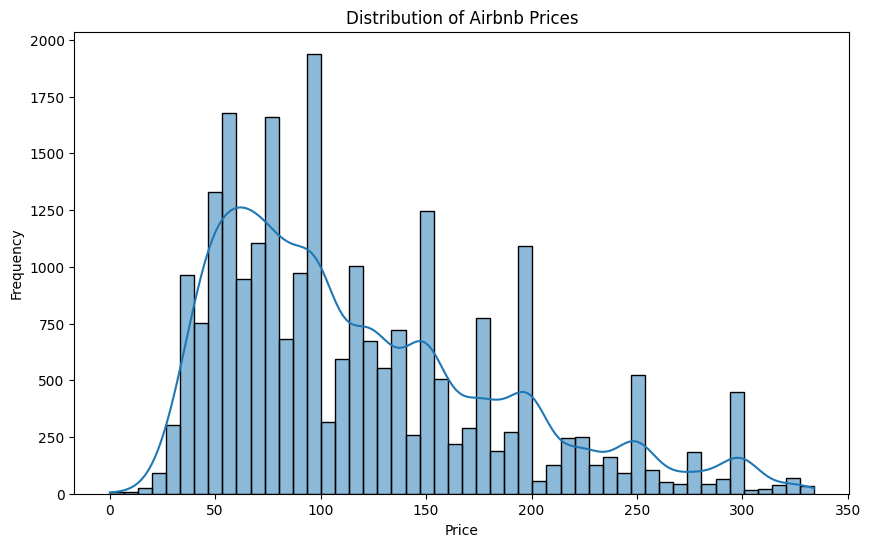

In [8]:
# Visualization of price distribution
plt.figure(figsize=(10, 6))
sns.histplot(prices['price'], bins=50, kde=True)
plt.title('Distribution of Airbnb Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

### 4.3 Categorical Data Analysis

room_type
entire home/apt    13266
private room       11346
shared room          587
Name: count, dtype: int64


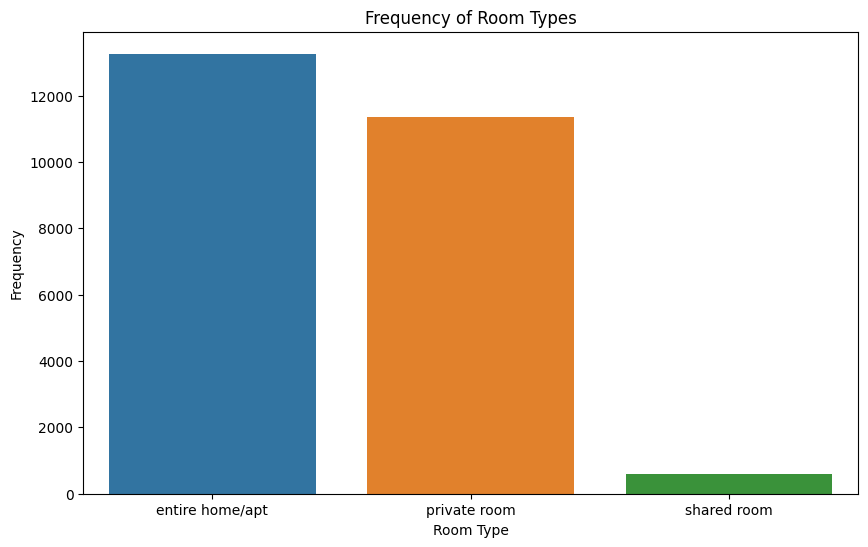

In [9]:
# Frequency of room types
room_frequencies = rooms['room_type'].value_counts()
print(room_frequencies)

# Bar chart of room type frequencies
plt.figure(figsize=(10, 6))
sns.barplot(x=room_frequencies.index, y=room_frequencies.values)
plt.title('Frequency of Room Types')
plt.xlabel('Room Type')
plt.ylabel('Frequency')
plt.show()

### 4.4 Time Series Analysis

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


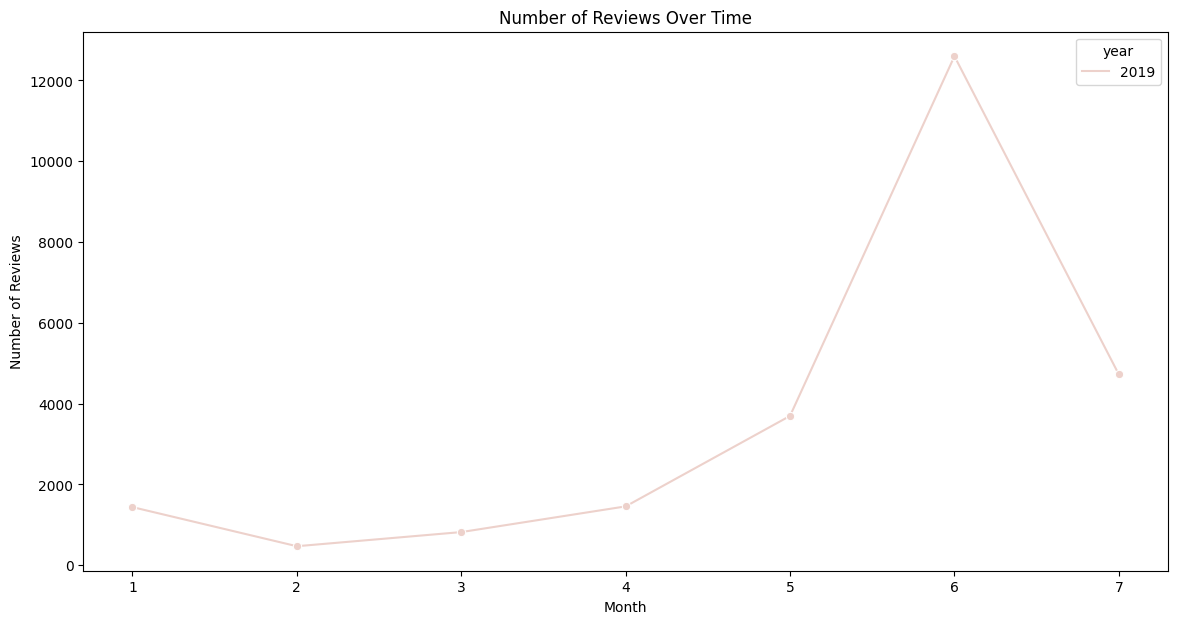

In [10]:
# Extract year and month
reviews['year'] = reviews['last_review'].dt.year
reviews['month'] = reviews['last_review'].dt.month

# Plot reviews over time
reviews_by_month = reviews.groupby(['year', 'month']). size().reset_index(name='counts')

plt.figure(figsize=(14, 7))
sns.lineplot(data=reviews_by_month, x='month', y='counts', hue='year', marker='o')
plt.title('Number of Reviews Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.show()


### 4.5 Correlation Analysis

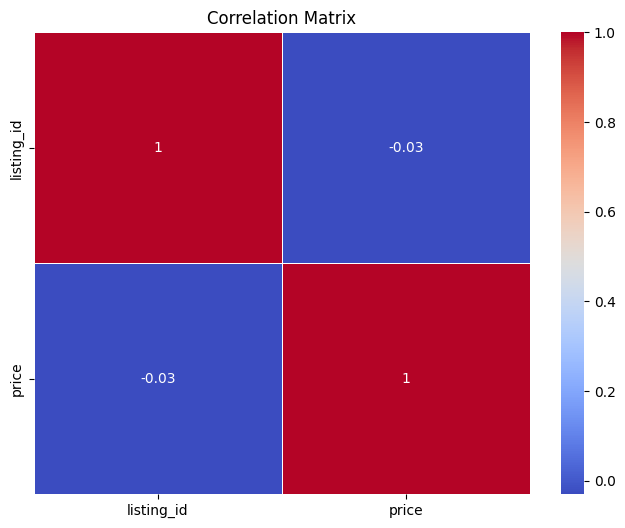

In [11]:
# Select only numerical columns from the prices dataset
numerical_columns = prices.select_dtypes(include=[np.number])

# Correlation matrix for numerical features
correlation_matrix = numerical_columns.corr()

# Heatmap of correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## 5. Combining Datasets

In [12]:
#There is a space character at the beginning of the column name, the space should be deleted
reviews.rename(columns={' listing_id': 'listing_id'}, inplace=True)

# Merge datasets on listing_id
combined_data = prices.merge(rooms, on='listing_id').merge(reviews, on='listing_id')
combined_data.head()

,listing_id,price,nbhood_full,borough,description,room_type,host_name,last_review,year,month
0,2595,225.0,"Manhattan, Midtown",Manhattan,Skylit Midtown Castle,entire home/apt,Jennifer,2019-05-21,2019,5
1,3831,89.0,"Brooklyn, Clinton Hill",Brooklyn,Cozy Entire Floor of Brownstone,entire home/apt,LisaRoxanne,2019-07-05,2019,7
2,5099,200.0,"Manhattan, Murray Hill",Manhattan,Large Cozy 1 BR Apartment In Midtown East,entire home/apt,Chris,2019-06-22,2019,6
3,5178,79.0,"Manhattan, Hell's Kitchen",Manhattan,Large Furnished Room Near B'way,private room,Shunichi,2019-06-24,2019,6
4,5238,150.0,"Manhattan, Chinatown",Manhattan,Cute & Cozy Lower East Side 1 bdrm,entire home/apt,Ben,2019-06-09,2019,6


## 6. Feature Engineering

In [13]:
# Example of feature engineering: calculate price per night in different seasons
# Assuming 'last_review' is indicative of the season
combined_data['season'] = combined_data['last_review'].dt.month % 12 // 3 + 1
combined_data['season'] = combined_data['season'].map({1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'})
combined_data.head()

,listing_id,price,nbhood_full,borough,description,room_type,host_name,last_review,year,month,season
0,2595,225.0,"Manhattan, Midtown",Manhattan,Skylit Midtown Castle,entire home/apt,Jennifer,2019-05-21,2019,5,Spring
1,3831,89.0,"Brooklyn, Clinton Hill",Brooklyn,Cozy Entire Floor of Brownstone,entire home/apt,LisaRoxanne,2019-07-05,2019,7,Summer
2,5099,200.0,"Manhattan, Murray Hill",Manhattan,Large Cozy 1 BR Apartment In Midtown East,entire home/apt,Chris,2019-06-22,2019,6,Summer
3,5178,79.0,"Manhattan, Hell's Kitchen",Manhattan,Large Furnished Room Near B'way,private room,Shunichi,2019-06-24,2019,6,Summer
4,5238,150.0,"Manhattan, Chinatown",Manhattan,Cute & Cozy Lower East Side 1 bdrm,entire home/apt,Ben,2019-06-09,2019,6,Summer


## 7. Answer Questions

### 7.1 Calculating average price

In [15]:
# Calculate the average price and round to nearest 2 decimal places, avg_price
avg_price = round(combined_data["price"].mean(),2)
# Print the average price
print("The average price per night for an Airbnb listing in NYC is ${}.".format(avg_price))

The average price per night for an Airbnb listing in NYC is $119.21.


### 7.2 Comparing costs to the private rental market
<p>Now we know how much a listing costs, on average, per night, but it would be useful to have a benchmark for comparison. 
According to <a href="https://www.zumper.com/rent-research">Zumper</a>, a 1 bedroom apartment in New York City costs, on average, $3,100 per month. Let's convert the per night prices of our listings into monthly costs, so we can compare to the private market. </p>

In [16]:
# Add a new column to the prices DataFrame, price_per_month
combined_data['price_per_month'] = combined_data['price'] * 365 / 12

# Calculate average_price_per_month
average_price_per_month = round(combined_data['price_per_month'].mean(),2)
# Compare Airbnb and rental market
print("Airbnb monthly costs are ${}, while in the private market you would pay {}."\
      .format(average_price_per_month, "$3,100.00"))

Airbnb monthly costs are $3625.94, while in the private market you would pay $3,100.00.


<p>Unsurprisingly, using Airbnb appears to be substantially more expensive than the private rental market. We should, however, consider that these Airbnb listings include single private rooms or even rooms to share, as well as entire homes/apartments. 
<br><br> 

## 6. What timeframe are we working with?
<p>It seems there is a fairly similar sized market opportunity for both private rooms (45% of listings) and entire homes/apartments (52%) on the Airbnb platform in NYC.
<br><br></p>
<p>Now let's turn our attention to the <code>reviews</code> DataFrame. The <code>last_review</code> column contains the date of the last review in the format of "Month Day Year" e.g., May 21 2019. We've been asked to find out the earliest and latest review dates in the DataFrame, and ensure the format allows this analysis to be easily conducted going forwards. </p>

In [17]:
# Create first_reviewed, the earliest review date
first_reviewed = combined_data["last_review"].dt.date.min()

# Create last_reviewed, the most recent review date
last_reviewed = combined_data["last_review"].dt.date.max()

# Print the oldest and newest reviews from the DataFrame
print("The latest Airbnb review is {}, the earliest review is {}".format(last_reviewed, first_reviewed))

The latest Airbnb review is 2019-07-09, the earliest review is 2019-01-01


### 7.4 Analyzing listing prices by NYC borough

<p>Now we have combined all data into a single DataFrame, we will turn our attention to understanding the difference in listing prices between <a href="https://en.wikipedia.org/wiki/Boroughs_of_New_York_City">New York City boroughs</a>.

                     sum    mean  median  count
borough                                        
Manhattan      1363929.0  145.75   135.0   9358
Brooklyn       1102387.0  108.88    95.0  10125
Queens          302324.0   88.45    70.0   3418
Staten Island    22974.0   86.04    71.0    267
Bronx            52477.0   76.05    64.0    690


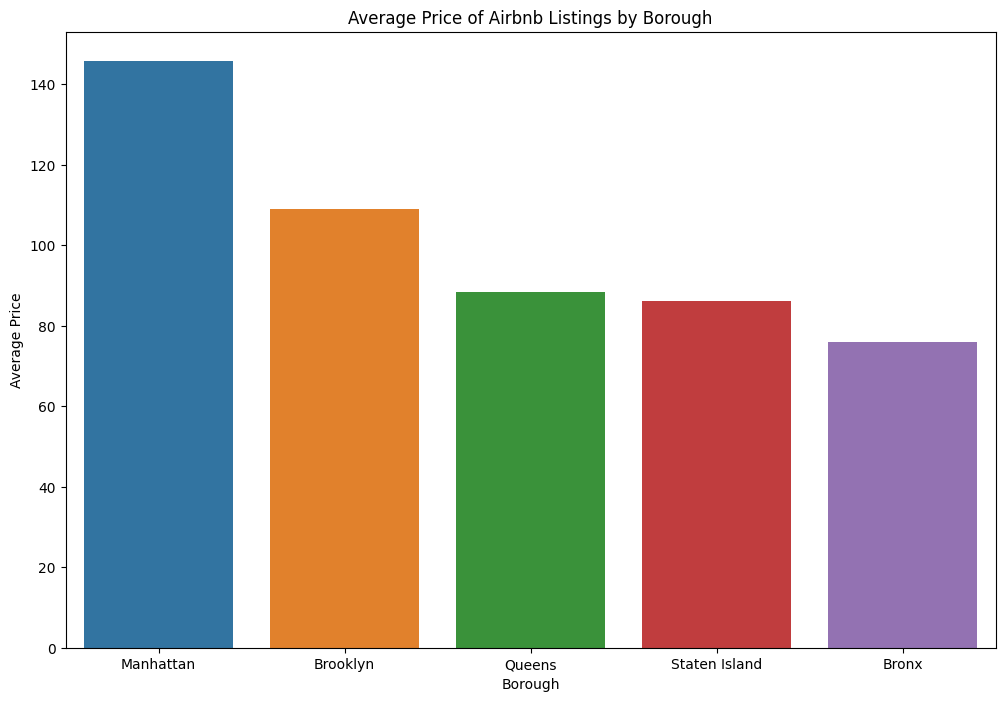

In [18]:
# Group by borough and calculate summary statistics
boroughs = combined_data.groupby("borough")["price"].agg(["sum", "mean", "median", "count"])

# Round boroughs to 2 decimal places, and sort by mean in descending order
boroughs = boroughs.round(2).sort_values("mean", ascending=False)

# Print boroughs
print(boroughs)

plt.figure(figsize=(12, 8))
sns.barplot(data=boroughs.reset_index(), x='borough', y='mean')
plt.title('Average Price of Airbnb Listings by Borough')
plt.xlabel('Borough')
plt.ylabel('Average Price')
plt.show()

### 7.5 Price Range Analysis
<p>The above output gives us a summary of prices for listings across the 5 boroughs. In this final task we would like to categorize listings based on whether they fall into specific price ranges, and view this by borough. 
<br><br>
We can do this using percentiles and labels to create a new column, <code>price_range</code>, in the DataFrame.
Once we have created the labels, we can then group the data and count frequencies for listings in each price range by borough.
<br><br>
We will assign the following categories and price ranges:</p>
<table>
<thead>
<tr>
<th>label</th>
<th>price</th>
</tr>
</thead>
<tbody>
<tr>
<td><code>Budget</code></td>
<td>\$0-69</td>
</tr>
<tr>
<td><code>Average</code></td>
<td>\$70-175</td>
</tr>
<tr>
<td><code>Expensive</code></td>
<td>\$176-350</td>
</tr>
<tr>
<td><code>Extravagant</code></td>
<td>&gt; \$350</td>
</tr>
</tbody>
</table>

/tmp/ipykernel_33/105845598.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prices_by_borough = combined_data.groupby(["borough", "price_range"])["price_range"].agg("count").unstack().fillna(0)


price_range    Budget  Average  Expensive  Extravagant
borough                                               
Bronx             381      285         24            0
Brooklyn         3194     5532       1399            0
Manhattan        1148     5285       2925            0
Queens           1631     1505        282            0
Staten Island     124      123         20            0


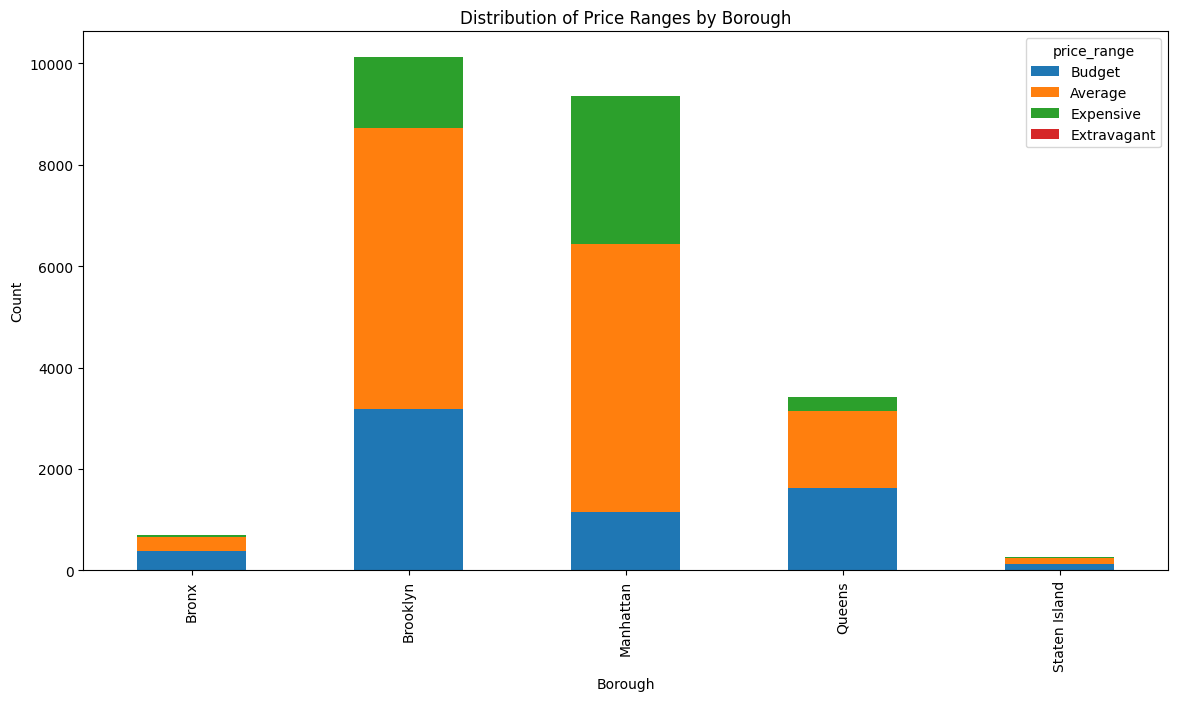

In [19]:
# Create labels for the price range, label_names
label_names = ["Budget", "Average", "Expensive", "Extravagant"]

# Create the label ranges, ranges
ranges = [0, 69, 175, 350, np.inf]

# Insert new column, price_range, into DataFrame
# Use `pd.cut` to segment and sort data values into bins
# Useful for going from a continuous variable to a categorical variable 
combined_data["price_range"] = pd.cut(combined_data["price"], bins=ranges, labels=label_names)

# Calculate borough and price_range frequencies, prices_by_borough
prices_by_borough = combined_data.groupby(["borough", "price_range"])["price_range"].agg("count").unstack().fillna(0)
print(prices_by_borough)

prices_by_borough.plot(kind='bar', stacked=True, figsize=(14, 7))
plt.title('Distribution of Price Ranges by Borough')
plt.xlabel('Borough')
plt.ylabel('Count')
plt.show()

## 8. Summary and Conclusion

### Summary of Findings
1. **Average Price of an Airbnb Listing in NYC:**
   - The average price varies significantly across different boroughs.
   - The overall distribution shows a high frequency of lower-priced listings, with some high-priced outliers.

2. **Price Comparison Across Boroughs:**
   - Manhattan has the highest average price, followed by Brooklyn.
   - Other boroughs like Queens, Bronx, and Staten Island have relatively lower average prices.

3. **Room Type Distribution:**
   - Most listings are entire homes/apartments, followed by private rooms.
   - Shared rooms and hotel rooms constitute a smaller portion of listings.

4. **Price Range Distribution by Borough:**
   - Manhattan has a higher concentration of expensive and extravagant listings.
   - Other boroughs have a higher proportion of budget and average listings.

### Conclusion
This analysis provides a comprehensive overview of the Airbnb market in NYC, highlighting significant differences in prices and types of listings across boroughs. Future work could explore seasonal trends and the impact of external factors on Airbnb pricing.